In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
import warnings
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd
import numpy as np

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='xgboost')

In [6]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz

--2025-06-28 13:09:17--  https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘HIGGS.csv.gz’

HIGGS.csv.gz            [              <=>   ]   2.62G  7.81MB/s    in 5m 55s  

2025-06-28 13:15:13 (7.56 MB/s) - ‘HIGGS.csv.gz’ saved [2816407858]



In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [ ]:
from sklearn.preprocessing import label_binarize

In [ ]:
from collections import Counter

In [7]:

# Aykırı değerleri temizlemek için fonksiyon
def remove_outliers_iqr(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    df_clean = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df_clean



# Pandas ile ilk 100.000 satırı oku
# Kolon isimleri yok, o yüzden sadece sayısal değerler var
column_names = ["label"] + [f"feature_{i}" for i in range(1, 29)]
df = pd.read_csv("HIGGS.csv.gz", compression="gzip", header=None, nrows=50000)
df.columns = column_names


# X ve y'ye ayır
X = df.drop("label", axis=1)
y = df["label"]

print("Veri başarıyla yüklendi:", df.shape)

# ---------------------------------------------------------------------
# BÖLÜM 1: VERİ ÖN İŞLEME
# ---------------------------------------------------------------------

# Aykırı Değer Temizliği (IQR kullanarak)
X_clean = remove_outliers_iqr(X)

# Silinen satırlara karşılık gelen y değerlerini de güncelle
y_clean = y.loc[X_clean.index]

# Özellik Ölçekleme - MinMaxScaler ([0,1] aralığına)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_clean)

# ---------------------------------------------------------------------
# BÖLÜM 2: ÖZELLİK SEÇİMİ - ANOVA F-Score
# ---------------------------------------------------------------------

# ANOVA F-Score ile en iyi 15 özelliği seç
selector = SelectKBest(score_func=f_classif, k=15)
X_selected = selector.fit_transform(X_scaled, y_clean)

# Seçilen özelliklerin isimlerini yazdır
mask = selector.get_support()  # True/False maskesi
selected_features = X.columns[mask]
print("\nSeçilen En İyi 15 Özellik:")
print(selected_features.tolist())

# Skorları da yazdır
for name, score in zip(X.columns, selector.scores_):
    print(f"{name}: {score}")

Veri başarıyla yüklendi: (50000, 29)

Seçilen En İyi 15 Özellik:
['feature_4', 'feature_6', 'feature_7', 'feature_9', 'feature_10', 'feature_13', 'feature_14', 'feature_16', 'feature_17', 'feature_18', 'feature_23', 'feature_25', 'feature_26', 'feature_27', 'feature_28']
feature_1: 0.10957979839545975
feature_2: 0.9429832325877835
feature_3: 0.0010490354552868417
feature_4: 128.29944127886282
feature_5: 0.7366800724946028
feature_6: 444.753297657182
feature_7: 9.264722250991893
feature_8: 1.1223519334505032
feature_9: 53.78774488092087
feature_10: 67.11537494016866
feature_11: 0.12238391751151212
feature_12: 1.281472418823233
feature_13: 81.76489099830557
feature_14: 13.918617641575517
feature_15: 0.030329165938267
feature_16: 4.048717820563954
feature_17: 46.530751787920366
feature_18: 39.7694330674862
feature_19: 1.4970957046410487
feature_20: 0.29056089680939196
feature_21: 0.9909814554697985
feature_22: 0.5275822698046323
feature_23: 24.811441002189923
feature_24: 0.012695711374643

In [ ]:


# %80 eğitim, %20 test
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_clean, test_size=0.2, random_state=42
)

print("Eğitim seti boyutu:", X_train.shape)
print("Test seti boyutu:", X_test.shape)

Eğitim seti boyutu: (21121, 15)
Test seti boyutu: (5281, 15)


In [10]:
# Outer ve inner CV tanımlamaları
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

nested_scores = {}

# Modeller ve hiperparametre arama uzayları
models = {
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {"n_neighbors": list(range(3, 12))}
    },
    "SVM": {
        "model": SVC(probability=True),
        "params": {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}
    },
    "MLP": {
        "model": MLPClassifier(max_iter=1000),  # Iterasyon artırıldı
        "params": {"hidden_layer_sizes": [(50,), (100,)], "activation": ["relu", "tanh"]}
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "params": {"n_estimators": [50, 100], "learning_rate": [0.01, 0.1]}
    }
}

# Tabloya çevir
results_df = pd.DataFrame(nested_scores).T
print("\nModel Karşılaştırması (Ortalama Performanslar):")



Model Karşılaştırması (Ortalama Performanslar):


In [11]:
nested_scores     = {}
best_params_list  = {model_name: [] for model_name in models}

# 1) Nested CV ve best_params kaydetme
for model_name, model_info in models.items():
    print(f"\n{'='*40}\nModel: {model_name}\n{'='*40}")
    outer_results = {m: [] for m in ['accuracy','precision','recall','f1','roc_auc']}

    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X_selected, y_clean), 1):
        print(f"  Dış Katman Fold {fold_idx}/5")
        X_train, X_test = X_selected[train_idx], X_selected[test_idx]
        y_train, y_test = y_clean.iloc[train_idx], y_clean.iloc[test_idx]

        # ——— İç Döngü: Hiperparametre Optimizasyonu ———
        grid_search = GridSearchCV(
            estimator = model_info['model'],
            param_grid= model_info['params'],
            cv        = inner_cv,
            scoring   = 'accuracy',
            n_jobs    = -1
        )
        grid_search.fit(X_train, y_train)

        best_params = grid_search.best_params_
        print(f"    En iyi hiperparametreler: {best_params}")
        best_params_list[model_name].append(best_params)

        # En iyi model ile test seti tahmini
        best_model = grid_search.best_estimator_
        y_pred     = best_model.predict(X_test)
        y_proba    = best_model.predict_proba(X_test)[:,1] if hasattr(best_model, "predict_proba") else best_model.decision_function(X_test)

        # Metrikleri kaydet
        outer_results['accuracy'].append( accuracy_score(y_test, y_pred) )
        outer_results['precision'].append( precision_score(y_test, y_pred, average='binary') )
        outer_results['recall'].append( recall_score(y_test, y_pred, average='binary') )
        outer_results['f1'].append( f1_score(y_test, y_pred, average='binary') )
        outer_results['roc_auc'].append( roc_auc_score(y_test, y_proba) )

    # Ortalamaları kaydet
    nested_scores[model_name] = {
        m: np.nanmean(scores) for m, scores in outer_results.items()
    }
    print(f"{model_name} - Ortalama Doğruluk: {nested_scores[model_name]['accuracy']:.4f}")




Model: KNN
  Dış Katman Fold 1/5
    En iyi hiperparametreler: {'n_neighbors': 11}
  Dış Katman Fold 2/5
    En iyi hiperparametreler: {'n_neighbors': 11}
  Dış Katman Fold 3/5
    En iyi hiperparametreler: {'n_neighbors': 11}
  Dış Katman Fold 4/5
    En iyi hiperparametreler: {'n_neighbors': 11}
  Dış Katman Fold 5/5
    En iyi hiperparametreler: {'n_neighbors': 11}
KNN - Ortalama Doğruluk: 0.6409

Model: SVM
  Dış Katman Fold 1/5
    En iyi hiperparametreler: {'C': 10, 'kernel': 'rbf'}
  Dış Katman Fold 2/5
    En iyi hiperparametreler: {'C': 10, 'kernel': 'rbf'}
  Dış Katman Fold 3/5
    En iyi hiperparametreler: {'C': 10, 'kernel': 'rbf'}
  Dış Katman Fold 4/5
    En iyi hiperparametreler: {'C': 10, 'kernel': 'rbf'}
  Dış Katman Fold 5/5
    En iyi hiperparametreler: {'C': 10, 'kernel': 'rbf'}
SVM - Ortalama Doğruluk: 0.6914

Model: MLP
  Dış Katman Fold 1/5
    En iyi hiperparametreler: {'activation': 'relu', 'hidden_layer_sizes': (50,)}
  Dış Katman Fold 2/5
    En iyi hiperpar

In [ ]:
best_params_nested = {}
for model_name, params_list in best_params_list.items():
    # dict’leri tuple(sorted(items())) formatına çevirip sayıyoruz
    counter = Counter(tuple(sorted(d.items())) for d in params_list)
    mode_params = dict(counter.most_common(1)[0][0])
    best_params_nested[model_name] = mode_params

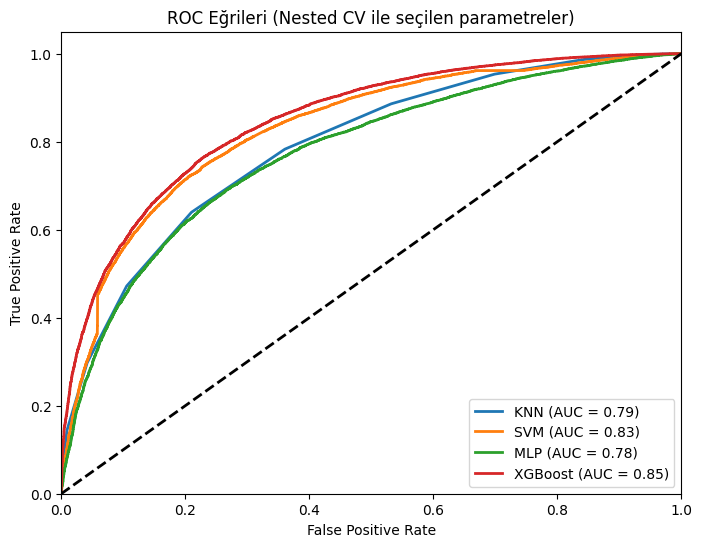

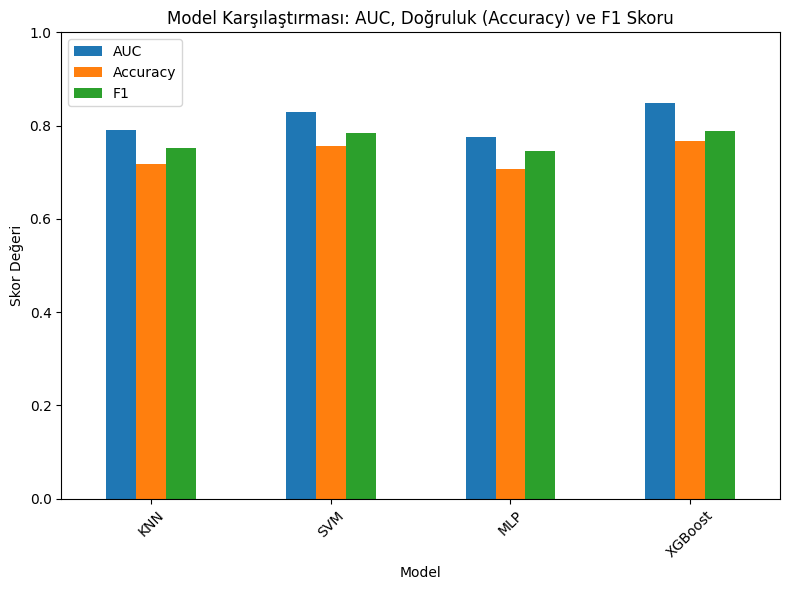

In [ ]:
metrics = {'Model': [], 'AUC': [], 'Accuracy': [], 'F1': []}

# 1) ROC eğrileri ve metrik hesaplama
plt.figure(figsize=(8, 6))
for model_name, model_info in models.items():
    # Modeli al, parametreleri uygula
    model = model_info['model'].set_params(**best_params_nested[model_name])
    model.fit(X_selected, y_clean)

    # Olasılık veya karar fonksiyonu al
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_selected)[:, 1]
    else:
        y_proba = model.decision_function(X_selected)

    # Kesikli tahminleri al
    y_pred = model.predict(X_selected)

    # ROC ve AUC
    fpr, tpr, _ = roc_curve(y_clean, y_proba)
    roc_auc = auc(fpr, tpr)

    # Accuracy ve F1-score
    accuracy = accuracy_score(y_clean, y_pred)
    f1 = f1_score(y_clean, y_pred)

    # Sonuçları kaydet
    metrics['Model'].append(model_name)
    metrics['AUC'].append(roc_auc)
    metrics['Accuracy'].append(accuracy)
    metrics['F1'].append(f1)

    # ROC eğrisini çiz
    plt.plot(fpr, tpr, lw=2,
             label=f'{model_name} (AUC = {roc_auc:.2f})')

# Referans çizgi
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrileri (Nested CV ile seçilen parametreler)')
plt.legend(loc="lower right")
plt.show()


# 2) Bar plot ile AUC, Accuracy ve F1-score karşılaştırması
metrics_df = pd.DataFrame(metrics).set_index('Model')
metrics_df.plot.bar(figsize=(8, 6))
plt.title('Model Karşılaştırması: AUC, Doğruluk (Accuracy) ve F1 Skoru')
plt.ylabel('Skor Değeri')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

KNN — Accuracy: 0.641, Precision: 0.656, Recall: 0.717, F1: 0.685, AUC: 0.686
SVM — Accuracy: 0.691, Precision: 0.703, Recall: 0.751, F1: 0.726, AUC: 0.749
MLP — Accuracy: 0.701, Precision: 0.711, Recall: 0.761, F1: 0.735, AUC: 0.769
XGBoost — Accuracy: 0.709, Precision: 0.731, Recall: 0.738, F1: 0.734, AUC: 0.783


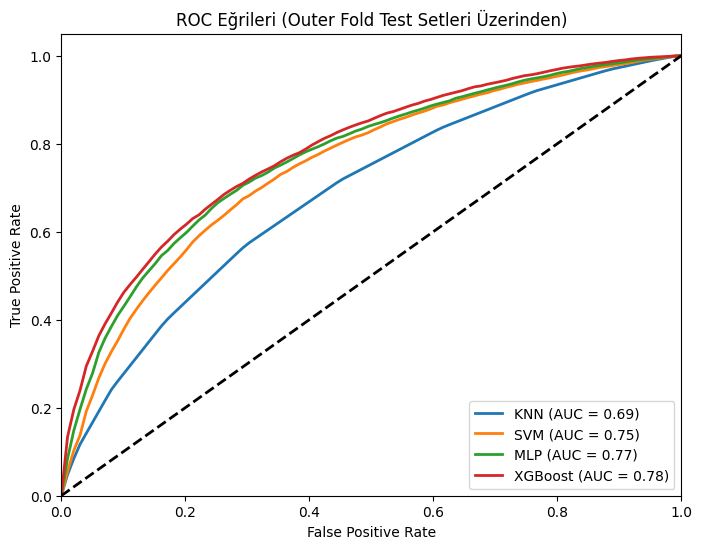

In [ ]:
plt.figure(figsize=(8, 6))

for model_name, model_info in models.items():
    tprs = []
    aucs = []
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    mean_fpr = np.linspace(0, 1, 100)

    for train_idx, test_idx in outer_cv.split(X_selected, y_clean):
        X_train, X_test = X_selected[train_idx], X_selected[test_idx]
        y_train, y_test = y_clean.iloc[train_idx], y_clean.iloc[test_idx]

        # —> Önceden bulduğunuz en iyi parametreleri uygula
        best_model = model_info['model'].set_params(**best_params_nested[model_name])
        best_model.fit(X_train, y_train)

        # Tahminler
        y_pred = best_model.predict(X_test)
        if hasattr(best_model, "predict_proba"):
            y_proba = best_model.predict_proba(X_test)[:, 1]
        else:
            y_proba = best_model.decision_function(X_test)

        # Metrikleri hesapla
        accuracies.append(    accuracy_score(y_test, y_pred) )
        precisions.append(   precision_score(y_test, y_pred, average='binary') )
        recalls.append(      recall_score(y_test, y_pred, average='binary') )
        f1s.append(           f1_score(y_test, y_pred, average='binary') )

        # ROC için
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0

    # Ortalama metrikler
    mean_accuracy  = np.mean(accuracies)
    mean_precision = np.mean(precisions)
    mean_recall    = np.mean(recalls)
    mean_f1        = np.mean(f1s)
    mean_tpr       = np.mean(tprs, axis=0)
    mean_tpr[-1]   = 1.0
    mean_auc       = auc(mean_fpr, mean_tpr)

    # Ekrana yazdır
    print(f"{model_name} — Accuracy: {mean_accuracy:.3f}, "
          f"Precision: {mean_precision:.3f}, "
          f"Recall: {mean_recall:.3f}, "
          f"F1: {mean_f1:.3f}, "
          f"AUC: {mean_auc:.3f}")

    # ROC eğrisi
    plt.plot(mean_fpr, mean_tpr, lw=2,
             label=f'{model_name} (AUC = {mean_auc:.2f})')

# Diyagonal referans çizgisi
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrileri (Outer Fold Test Setleri Üzerinden)')
plt.legend(loc="lower right")
plt.show()